# Introduction

- In these series of notebooks, we will explore how to create an image recognition model from scratch in Pytorch.



- This first notebook will be the backbone of our analysis. We will gradually improve our model with new techniques and methods.Therefore, we should focus on the concepts rather than model performance. 



- We will create a neural network model that can recognize different snickers brands. We have 6 classes of images in this problem 
        
        
                       'adidas', 'converse','new-balance', 'nike', 'reebok', 'vans'
 


- **Our task is now to classify a given image as one of those classes**. Carefully inspect the sections of this notebook at the very top. It represents a generic flow of an image recognition model pipeline. Each step has its own techniques and challenges. We will discuss everything in details.   

## Preprocessing and Data Loading

### Import necessary modules

In [1]:
%matplotlib inline
#==============================#
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
#===========================#
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
#============================#
import time
import os
import copy
import random
import sys
from collections import Counter
from torchinfo import summary
import warnings
warnings.filterwarnings('ignore') 
#===custom functions===========#


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))


#make your reproducible 
def Seed_Everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

Seed_Everything()

NVIDIA GeForce RTX 2070 Super


### Data Preprocessing

- Your data directory must look something like as follows. Files names, extension etc can be different, I display just a few files names. In any image classification problem in Pytorch, it is very important to have this structure, otherwise we will get an error at the very first stage of data loading.

                                snicker_data/
                                ├── test
                                │   ├── adidas
                                │   ├── converse
                                │   ├── new-balance
                                │   ├── nike 
                                │   ├── reebok 
                                │   └── vans  
                                ├── train
                                │   ├── adidas 
                                │   ├── converse 
                                │   ├── new-balance 
                                │   ├── nike  
                                │   ├── reebok 
                                │   └── vans 


In [2]:
#CreateTrainTest("snicker_data/")

In [3]:
#train-test split if you have not done before
# from utils import create_train_test
# CreateTrainTest('snicker_data')

### Loading the Data via Pytorch DataLoader

- Pytorch provides several classes which make the data loading easy and fast. Depending on the dataset, we may need to write our own loader on top of Pytorch DataLoader class.


- It is essential to perform *data augmentation* on the training data. We will discuss this topic in next sections in details. For now, we need to resize each image and convert to Pytorch tensor before feeding to our model. Pytorch *transforms* takes care of everything for us.


- After that, we will load the data using Pytorch *DataLoader* class. As we discuss before, we will feed the images in batches to our model. For example, our batch size is 4 in this problem. This means we literally feed 4 images in a single forward pass and perform gradient decent and keep repeating this until we exhaust our training images.  


In [4]:
train_dir = "snicker_data/train/"
test_dir = "snicker_data/test"

In [5]:
#reading and loading the data
width = 128
height = 128
training_transforms = transforms.Compose([transforms.Resize((width,height)),transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((width,height)),transforms.ToTensor()])


train_set = datasets.ImageFolder(train_dir, transform = training_transforms)
test_set  = datasets.ImageFolder(test_dir, transform = test_transforms)

batch_size = 4
train_loader = DataLoader(train_set,batch_size = batch_size,shuffle=True)
test_loader = DataLoader(test_set,batch_size = batch_size)

- Carefully look at the following outputs. Our model will have 2 output neurons representing two classes we have. In terms of labels erdi=0 and other=1. We have 18 training images in erdi class and 16 training images in other class.

In [6]:
class_list = train_set.classes
class_to_idx = train_set.class_to_idx
print(class_to_idx)
idx_to_class = {i:j for i, j in enumerate(class_list)}
num_classes = len(class_list)
class_counts = torch.bincount(torch.tensor(train_set.targets)).tolist()

print(class_counts)

{'adidas': 0, 'converse': 1, 'new-balance': 2, 'nike': 3, 'reebok': 4, 'vans': 5}
[90, 98, 92, 95, 95, 93]


- The following output is important. Since we set **batch_size = 4**, we have 4 images in each 'load' and 4 labels corresponding to each of these images. Remember the convention in Pytorch

                            (Batch,Channel,Width,Height)

    We have 4 images, they all have 1 channel since we are working with gray-scale images and they are of width and height 128 since they are all resized to (128,128) beforehand.


- In this batch all images are coming from "other" as we see from the labels. If you provide "shuffle=True" option in DataLoader object above, we would probably see different labels. It actually improves model training but for now, let's skip it.

In [7]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels)

torch.Size([4, 3, 128, 128])
tensor([5, 1, 1, 0])


In [8]:
#80%-20%
print(f'train_set has {len(train_set)} images')
print(f'testing_set has {len(test_set)} images')

train_set has 563 images
testing_set has 142 images


In [9]:
def get_data_paths(train_dir, test_dir):
    train_image_paths = []
    test_image_paths = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):
        for names in filenames:
            train_image_paths.append(os.path.join(dirpath, names))
    for (dirpath, dirnames, filenames) in os.walk(test_dir):
        for names in filenames:
            test_image_paths.append(os.path.join(dirpath, names))

    random.shuffle(train_image_paths)
    random.shuffle(test_image_paths)

    return train_image_paths, test_image_paths

train_image_paths,test_image_paths = get_data_paths(train_dir, test_dir)

In [10]:
train_image_paths[:3]

['snicker_data/train/nike/n104.jpeg',
 'snicker_data/train/converse/c110.jpeg',
 'snicker_data/train/adidas/a060.jpeg']

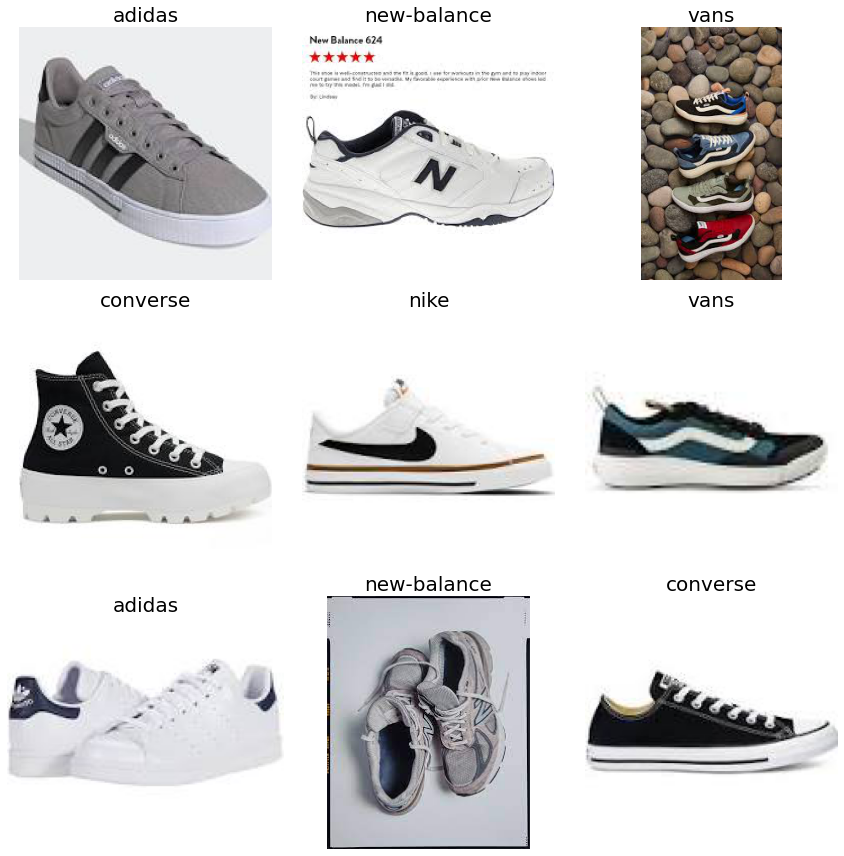

In [11]:
#view some samples in nxn grid
def view_samples(n, img_paths):
    plt.figure(figsize=(12, 12))
    img_lst = random.sample(img_paths, n * n)
    for i, img_path in enumerate(img_lst):
        img = Image.open(img_path).convert("RGB")
        label = img_path.split('/')[-2]
        plt.subplot(n, n, i + 1)
        plt.subplots_adjust(wspace=0.01, hspace=0.001)
        plt.title(label, fontsize=20)
        plt.axis('off')
        plt.imshow(img)
    plt.tight_layout()
    plt.show()
view_samples(n=3, img_paths=train_image_paths)

- A common practice is to check the class distributions. It is important to have almost the same number of images from each class type. Otherwise, the model will struggle to learn the minority class. There are very well established methods(oversampling, use class weights etc) to deal with this issue but we will reserve them for another lecture.

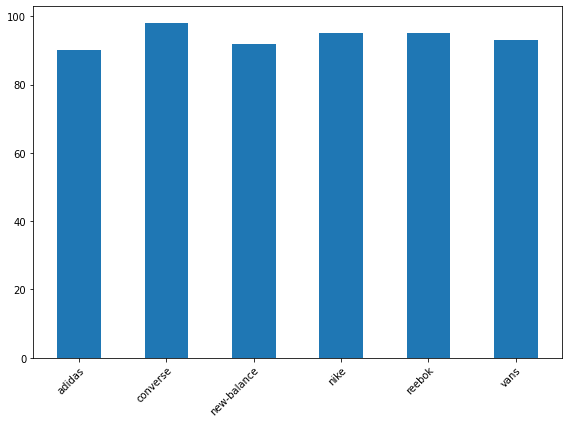

In [12]:
def view_class_dist(class_list, class_counts):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(class_list, class_counts, width=0.5, align='center')
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.tight_layout()
    plt.show()
    
view_class_dist(class_list, class_counts)

# Build the Model 

As the first step, let's build a fully connected network with 3 hidden layers having 64,32,16 neurons, respectively.

In [13]:
# Extent nn.Module to create a custom FCN
class SnickerModel(nn.Module):
    def __init__(self):
        super(SnickerModel,self).__init__()
        
        self.fc1 = nn.Linear(3*width*height, 64)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()
        
        self.out = nn.Linear(16, num_classes)
            
    def forward(self, t):

        t = torch.flatten(t,1)
        t = self.relu1(self.fc1(t))
        t = self.relu2(self.fc2(t))
        t = self.relu3(self.fc3(t))
                
        t = self.out(t)
        
        return t

In [14]:
model = SnickerModel()
summary(model,input_size=(batch_size,3,width,height))

Layer (type:depth-idx)                   Output Shape              Param #
SnickerModel                             [4, 6]                    --
├─Linear: 1-1                            [4, 64]                   3,145,792
├─ReLU: 1-2                              [4, 64]                   --
├─Linear: 1-3                            [4, 32]                   2,080
├─ReLU: 1-4                              [4, 32]                   --
├─Linear: 1-5                            [4, 16]                   528
├─ReLU: 1-6                              [4, 16]                   --
├─Linear: 1-7                            [4, 6]                    102
Total params: 3,148,502
Trainable params: 3,148,502
Non-trainable params: 0
Total mult-adds (M): 12.59
Input size (MB): 0.79
Forward/backward pass size (MB): 0.00
Params size (MB): 12.59
Estimated Total Size (MB): 13.38

- The above output tells us we have around 4M parameters in this small model. Let's work it out. 

            Layer1: 3*128*128 input x 64 output = 3,145,728 weights + 64 biases = 3,145,792 parameters
            Layer2: 64 inputs x 32 outputs = 2048 weights + 32 biases = 2080 parameters
            Layer3: 32 inputs x 16 outputs = 512 weights + 16 biases = 528 parameters
            Layer4: 16 inputs x 6 outputs = 96 weighs + 6 biases = 102 parameters 
            TOTAL = 3,148,502



- Recall that forward pass works like 
\begin{equation*}
z^{i} = \mathbf{W}^{i}a^{i-1}+b^{i} \\
a^{i} = \sigma(z^{i})
\end{equation*}

where $i=1.2... L$ and $\sigma$ is the predefined activation function. Dimension of the weight matrix $\mathbf{W}^{i}$ is $MxN$ where
M is the number of neurons in the $(i+1)^{th}$ layer and N is the number of neurons in the $i^{th}$ layer. The bias $b$ is $Nx1$.


In [15]:
#carefully examine what we have here
print(f'W_1: {model.fc1.weight.shape}    b_1: {model.fc1.bias.shape} ')
print(f'W_2: {model.fc2.weight.shape}    b_2: {model.fc2.bias.shape} ')
print(f'W_3: {model.fc3.weight.shape}    b_3: {model.fc3.bias.shape} ')
print(f'W_4: {model.out.weight.shape}    b_4: {model.out.bias.shape} ')

W_1: torch.Size([64, 49152])    b_1: torch.Size([64]) 
W_2: torch.Size([32, 64])    b_2: torch.Size([32]) 
W_3: torch.Size([16, 32])    b_3: torch.Size([16]) 
W_4: torch.Size([6, 16])    b_4: torch.Size([6]) 


- Let's take a batch from dataloader, compute in the model and interpret the output. At this point, we did not train the model. Model predictions are completely random.


- We have 4 "**adidas**" images in the batch and model predictions are 4x6 tensor. First row is the prediction for the first image. The index of the largest entry is 2, thus model prediction is "new-balance", so this prediction is wrong.Second row tells us the prediction is "balance" again since the index of the largest entry is 2 . So this prediction is also wrong. 

In [16]:
model = SnickerModel()
images,labels = next(iter(train_loader))
outputs = model(images)
print(f'labels\n {labels}')
print(f'outputs\n {outputs}')

labels
 tensor([2, 2, 1, 0])
outputs
 tensor([[-0.0976,  0.2123,  0.0710, -0.1835, -0.0080, -0.2530],
        [-0.1070,  0.2011,  0.0782, -0.1907, -0.0114, -0.2488],
        [-0.0898,  0.2127,  0.0678, -0.1799, -0.0082, -0.2441],
        [-0.1145,  0.2082,  0.0761, -0.2017, -0.0138, -0.2405]],
       grad_fn=<AddmmBackward0>)


# Train and Test


- In a typical supervised learning task, we have training and testing functions. We then call this functions in order to monitor the progress of our model. More precisely, train and test the model in each epoch. 


- Carefully inspect the both code blocks. **"run_model"** function train or test your model based on the "mode". Notice that if the mode='train', we perform gradien decent on tranining data as we discussed before. If mode='test', we just evaluate the model on testing data. Each call of this function train or test the model only once.



-  **"train_test_model"** function is the driver function to train and test our model for multiple epochs. It is always a good practice to save the 'best performing model'. This means, we will keep track of the 'best accuracy' in each epoch and save the model achieving that best accuracy. This is important because we can then load this model and start training from where we left off. 


- It is not reasonable to expect a good performance from a fully connected neural network on RGB images. Moreover, we will not spend any time to improve the model. Thus, just focus on the concepts for now. We will discuss about potential improvement techniques in the later sections.


- In the next notebook, we will put all these functions in "utils.py" and import them to use it. Our code will be much more clean then.

In [17]:
def run_model(model, data_loader, optimizer=None, mode='train'):
    # Check if the mode is valid ('train' or 'test')
    assert mode in ['train', 'test'], "Invalid mode, choose either 'train' or 'test'"

    # Set the model to training mode if mode is 'train', otherwise set it to evaluation mode
    if mode == 'train':
        model.train()
    else:
        model.eval()

    # Send the model to the device (GPU or CPU)
    model.to(device)

    # Initialize the loss function (CrossEntropyLoss for multi-class classification)
    criterion = nn.CrossEntropyLoss()

    # Initialize variables to store total loss and total correct predictions
    total_loss = 0.0
    total_correct = 0

    # Iterate through the data loader (either train or test)
    for i, (images, labels) in enumerate(data_loader):
        # Clear the CUDA cache to free up memory
        torch.cuda.empty_cache()

        # Send images and labels to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)

        # Compute the model output (predictions) for the current batch of images
        outputs = model(images)

        # Calculate the loss using the criterion defined above
        loss = criterion(outputs, labels)

        # If in training mode, perform backpropagation and update model weights
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Accumulate the loss for the current batch
        total_loss += loss.item() * images.size(0)

        # Get the predicted class for each image in the batch
        predictions = outputs.argmax(dim=1)

        # Compare the predicted class with the true label, and count the correct predictions
        correct_counts = predictions.eq(labels)

        # Accumulate the total correct predictions for all batches
        total_correct += correct_counts.sum().item()

    # Calculate the average loss and accuracy for the entire dataset
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)

    # Return accuracy and average loss
    return accuracy, avg_loss


In [18]:
def train_test_model(model, train_loader, test_loader, optimizer, num_epochs=1,log_int=1,model_name='best_model'):
    # Lists to store losses and accuracies for each epoch
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Initialize the best test accuracy to 0.0
    best_test_accuracy = 0.0
    
    #train time
    start_time=time.time()
    
    # Iterate through each epoch
    for epoch in range(num_epochs):
        # Train the model using the 'run_model()' function in 'train' mode
        train_acc, train_loss = run_model(model, train_loader, optimizer, mode='train')
        # Append the training loss and accuracy for the current epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Test the model using the 'run_model()' function in 'test' mode
        test_acc, test_loss = run_model(model, test_loader, mode='test')
        
        # Append the test loss and accuracy for the current epoch
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print the train and test accuracy for the current epoch
        if (epoch+1)%log_int==0:
            print(f"Epoch {epoch + 1}/{num_epochs} train_acc: {train_acc * 100:.2f}%, test_acc: {test_acc * 100:.2f}%")

        # Check if the current test accuracy is greater than the best test accuracy
        if test_acc > best_test_accuracy:
            # Update the best test accuracy
            best_test_accuracy = test_acc
            
            # Save the model's state dictionary with some stats
            best_state_dic = copy.deepcopy(model.state_dict())
            beststats = {'BestTestAcc': best_test_accuracy,
                         'lr': optimizer.param_groups[0]['lr'],
                         }
            checkpoint = {'state_dict': best_state_dic,
                          'best_stats': beststats
                          }
            #save the model
            torch.save(checkpoint, f"{model_name}.pth")
            
    
    end_time  = time.time()
    print(f"Traning finished in {end_time-start_time:0.1f}sec")
    return best_test_accuracy
    
    

In [19]:
num_epochs = 40
lr = 4e-3
log_int = 5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_test_model(model, train_loader, test_loader, optimizer, num_epochs,log_int)

Epoch 5/40 train_acc: 17.41%, test_acc: 16.20%
Epoch 10/40 train_acc: 17.41%, test_acc: 16.20%
Epoch 15/40 train_acc: 17.41%, test_acc: 16.20%
Epoch 20/40 train_acc: 17.05%, test_acc: 16.20%
Epoch 25/40 train_acc: 15.81%, test_acc: 16.20%
Epoch 30/40 train_acc: 15.99%, test_acc: 16.20%
Epoch 35/40 train_acc: 16.34%, test_acc: 16.20%
Epoch 40/40 train_acc: 16.34%, test_acc: 16.20%
Traning finished in 41.6sec


0.1619718309859155

- Clearly what's happening above is that the model is nor learning anything as we can see from trainining acccuracies. Everyhing looks just random. This is something we expected and we know how to fix it.


- Next step is to improve our model architecture using exactly the same train_test_model function.

# What is Next

- We built our first neural network model and it has 17% overall accuracy. Our next step is to build a a **convolutional neural network**. Every piece of our code will be exactly the same except the model architecture.

- We will also evaluate the model performance by inspecting Recall, Precision and F1 score.

- Since we are using the same functions, we will actually put them in a separate Python file called "utils.py" we already have and import them from this file rather. This will help us to have a clean, nice, easy-to-read Jupyter notebook.


- Moreover, we will not repeat the same argument over again in the next notebooks, we will rather focus on the details. Thus, it is important to keep up with the flow of the course.